In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),  transforms.Normalize((0.1307,), (0.3081,))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [3]:
batch_size = 96

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
print len(train_loader), len(test_loader)

625 105


In [5]:
ip_dim = 28*28
z_dim = 10
comb_dim = ip_dim + z_dim

In [6]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = (self.l3(x))
        
        return x

In [7]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,800)
        self.l2 = nn.Linear(800,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,500)
        self.l5 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = F.tanh(self.l5(x))
        
        return x

In [8]:
class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(ip_dim,100)
        #self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,100)
        self.l4 = nn.Linear(50,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        #x = F.leaky_relu(self.l2(x))
        x = F.sigmoid(self.l3(x))
        
        return x

In [9]:
G = decoder().cuda()
E = encoder().cuda()
D = disc().cuda()

In [10]:
def clear_grad():
    G.zero_grad()
    #E.zero_grad()
    D.zero_grad()

In [11]:
E_solver = optim.Adam(E.parameters(),lr = 1e-3)
G_solver = optim.Adam(G.parameters(),lr = 1e-2,weight_decay=1e-2)
D1_solver = optim.Adam(D.parameters(),lr = 1e-4)
D0_solver = optim.Adam(D.parameters(),lr = 1e-3)

###  Initially train with BCE loss

In [12]:
epochs = 30
for ep in range(epochs):
    for idx,(x,label) in enumerate(train_loader):
        
        x = x.view(batch_size,28*28)
        x = Variable(x.cuda(),requires_grad = False)
        
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        xhat = G(z)
        g_loss = nn.MSELoss()(xhat,x)
        g_loss.backward()
        G_solver.step()
        clear_grad()
    print(g_loss.data[0])

0.743095219135
0.73493462801
0.762349784374
0.74689245224
0.704093396664
0.714151263237
0.709716200829
0.696048080921
0.722295761108
0.736637115479
0.685199081898
0.71788674593
0.763336360455
0.698856115341
0.713256955147
0.693974494934
0.721129596233
0.716451406479
0.715591013432
0.730312168598
0.744190633297
0.696163415909
0.724393904209
0.716960012913
0.723156750202
0.70235824585
0.699847817421
0.741686940193
0.738591551781
0.727178275585


In [13]:
epochs = 50
for ep in range(epochs):
    for idx,(x,label) in enumerate(train_loader):
        
        x = x.view(batch_size,28*28)
        x = Variable(x.cuda())
        
        #zhat = E(x)
        
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        xhat = G(z)
        
        ## Discriminator loss ##
        
        d_true = D(x)
        d_false = D(xhat)
        
        add_tiny = 1e-10
        
        if(ep%1 == 0):
            d_loss1 = nn.BCELoss()(d_true,Variable(torch.ones(d_true.size()).cuda()))
            d_loss1.backward(retain_graph = True)
            d_loss2 = nn.BCELoss()(d_false,Variable(torch.zeros(d_false.size())).cuda())
            d_loss2.backward(retain_graph = True)
            #d_loss = -(torch.mean(torch.log(d_true + add_tiny) + torch.log((1-d_false) + add_tiny)))
            #d_loss.backward(retain_graph= True)
            D0_solver.step()
        
            clear_grad()
        
        ## Generator Loss ##
        
        d_false = D(xhat)
        g_loss = nn.BCELoss()(d_false,Variable(torch.ones(d_false.size()).cuda()))
        g_loss = -torch.mean(torch.log(d_false + add_tiny)) + 0.1*nn.MSELoss()(xhat,x)
        g_loss.backward()
       # D1_solver.step()
        G_solver.step()
        
        clear_grad()
        
    print((d_loss1+d_loss2).data[0],g_loss.data[0])

(1.545816421508789, 0.6348524689674377)
(1.0087379217147827, 3.9255428314208984)
(8.104669570922852, 0.1335708051919937)
(1.394392728805542, 0.8321279287338257)
(1.2014310359954834, 0.9631125330924988)
(1.4422893524169922, 0.7577905058860779)
(0.1900748461484909, 5.482553005218506)
(1.1048508882522583, 1.0216397047042847)
(0.2562251687049866, 7.67146110534668)
(0.768159031867981, 1.4790114164352417)
(1.0974057912826538, 1.1126580238342285)
(0.05540050193667412, 6.945626735687256)
(25.03571319580078, 0.18921634554862976)
(1.6095576286315918, 0.98798668384552)
(1.6328438520431519, 1.1052435636520386)
(0.5392376184463501, 2.0490493774414062)
(1.4967983961105347, 2.1165125370025635)
(1.2368985414505005, 1.7636340856552124)
(0.9343772530555725, 1.0488476753234863)
(0.6140216588973999, 5.32877254486084)
(1.32639479637146, 0.9238998889923096)
(0.7475924491882324, 1.659198522567749)
(0.4037317633628845, 1.990234136581421)
(1.0500928163528442, 1.4275308847427368)
(0.0036560939624905586, 6.47177

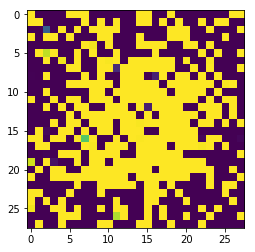

In [14]:
z_check = Variable(torch.randn(1,z_dim)).cuda()
op = G(z_check)
op = op.resize(28,28)
op = op.data.cpu().numpy()
plt.imshow(op)
plt.show()

In [15]:
torch.max(x)

Variable containing:
 2.8215
[torch.cuda.FloatTensor of size 1 (GPU 0)]